In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy

df = pd.read_csv("quera-karyabi.csv")

In [5]:
# نمایش ابعاد داده‌ها
print("ابعاد دیتافریم:", df.shape)

ابعاد دیتافریم: (200000, 15)


In [6]:
# نمایش تعداد مقادیر null در هر ستون
print("\nتعداد مقادیر null در هر ستون:")
print(df.isnull().sum())


تعداد مقادیر null در هر ستون:
Applicant ID                                             4200
Source                                                      0
Order                                                       0
Developer State                                             0
Seen                                                        0
Job ID                                                      0
Job Title                                                   0
Careers Job - Job → Level                               13833
Careers Job - Job → Offers Remote                           0
Careers Job - Job → Minimum Salary                     150958
Careers Job - Job → Maximum Salary                     151618
Careers Job - Job → Hit Count                               0
Accounts City - City → Name                             87806
Careers Disqualifyreason - Disqualify Reason → Name    137137
Job_ID_Title                                                0
dtype: int64


In [ ]:
# حذف سطرهایی که ستون Applicant ID مقدار null دارند
df = df[df["Applicant ID"].notnull()]

In [ ]:
# حذف سطرهایی که ستون‌های Applicant ID، Job ID یا Job Title مقدار null دارند
df = df[
    df["Applicant ID"].notnull() & df["Job ID"].notnull() & df["Job Title"].notnull()
]

In [ ]:
normalization_map = {
    # --- Roles / نقش‌ها ---
    "برنامه نویسی": "developer",
    "برنامه‌نویسی": "developer",
    "برنامه نویس": "developer",
    "برنامه‌نویس": "developer",
    "توسعه دهنده": "developer",
    "توسعه‌دهنده": "developer",
    "مهندس نرم افزار": "software engineer",
    "مهندس نرم‌افزار": "software engineer",
    "کارشناس نرم افزار": "software specialist",
    "کارشناس نرم‌افزار": "software specialist",
    "توسعه دهنده نرم افزار": "software developer",
    "توسعه‌دهنده نرم‌افزار": "software developer",
    "پشتیبان": "support",
    "تحلیلگر": "analyst",
    "تحلیل گر": "analyst",
    "طراح": "designer",
    "مدیر": "manager",
    "متخصص": "specialist",
    "کارشناس": "specialist",
    # --- Levels / سطوح ---
    "ارشد": "senior",
    "سنیور": "senior",
    "جونیور": "junior",
    "کارآموز": "intern",
    "کاراموز": "intern",
    "تازه کار": "junior",
    "تازهکار": "junior",
    "میدلول": "mid-level",
    "mid level": "mid-level",
    # --- Technologies & Fields / تکنولوژی‌ها و حوزه‌ها ---
    "تحلیل": " analysis",
    "تحلیلگر داده": "data analyst",
    "ساینس": "science",
    "ساینتیست": "scientist",
    "وب": "web",
    "لاراول": "laravel",
    "نرم‌افزار": "software",
    "جنگو": "django",
    "پایتون": "python",
    "جاوااسکریپت": "javascript",
    "جاوا اسکریپت": "javascript",
    "پی اچ پی": "php",
    "پی‌اچ‌پی": "php",
    "سی شارپ": "c#",
    "سی‌شارپ": "c#",
    "دات نت": ".net",
    "دات‌نت": ".net",
    "فرانت اند": "frontend",
    "فرانت‌اند": "frontend",
    "بک اند": "backend",
    "بک‌اند": "backend",
    "فول استک": "fullstack",
    "دواپس": "devops",
    "دوآپس": "devops",
    "هوش مصنوعی": "artificial intelligence",
    "یادگیری ماشین": "machine learning",
    "دیتا": "data",
    "داده": "data",
    "ساینتیست": "scientist",
    "دانشمند": "scientist",
    "علم داده": "data science",
    "اندروید": "android",
    "آی او اس": "ios",
    "آی‌او‌اس": "ios",
    "موبایل": "mobile",
    "امنیت": "security",
    "شبکه": "network",
    "اس کیو ال": "sql",
    "پایگاه داده": "database",
    "داده": "data",
    "دورکاری": "intern",
    "-": "",
    # --- Character Normalization / نرمال‌سازی کاراکترها ---
    "ك": "ک",  # کاف عربی به فارسی
    "ي": "ی",  # یای عربی به فارسی
}

import re


def normalize_title(title):
    if not isinstance(title, str):
        return ""  # یا هر مقدار پیش‌فرض دیگر برای داده‌های غیرمتنی

    title = title.lower()
    for key, value in normalization_map.items():
        title = title.replace(key, value)
    title = re.sub(r"\s+", " ", title).strip()

    return title


original_title_column = "Job Title"
normalized_title_column = "normal_title"

# اعمال تابع روی ستون و ساخت ستون جدید
df[normalized_title_column] = df[original_title_column].apply(normalize_title)


def get_job_domain(title):
    """
    عنوان شغلی را به یک حوزه اصلی (Domain) دسته‌بندی می‌کند.
    """
    title = str(title).lower()

    ai_data_keywords = [
        "data scientist",
        "machine learning",
        "یادگیری ماشین",
        "هوش مصنوعی",
        "artificial intelligence",
        "تحلیلگر داده",
        "تحلیل",
        "data analyst",
        "data engineer",
        "مهندس داده",
        "data science",
        "علم داده",
        "داده کاوی",
        "big data",
        "بیگ دیتا",
    ]
    backend_keywords = [
        "backend",
        "back-end",
        "بک اند",
        "django",
        "flask",
        "net.",
        "fastapi",
        "node.js",
        "php",
        "laravel",
        "c#",
        "back end",
        ".net",
        "java",
        "spring",
        "go",
        "python",
        "python developer",
        "ruby",
        "ruby on rails",
        "rails",
        ".net",
        "nodejs",
    ]
    frontend_keywords = [
        "frontend",
        "front-end",
        "فرانت اند",
        "react",
        "vue",
        "angular",
        "javascript",
        "web",
        "front end",
    ]
    android_keywords = [
        "android",
        "اندروید",
        "kotlin",
        "کاتلین",
        "jetpack",
        "compose",
        "موبایل",
        "flutter",
        "ios",
    ]
    uiux_keywords = ["ui", "ux", "uiux", "designer", "دیزاینر", "figma"]

    if any(keyword in title for keyword in ai_data_keywords):
        return "AI_Data"
    elif any(keyword in title for keyword in android_keywords):
        return "Android"
    elif any(keyword in title for keyword in backend_keywords):
        return "Backend"
    elif any(keyword in title for keyword in frontend_keywords):
        return "Frontend"
    elif any(keyword in title for keyword in uiux_keywords):
        return "UIUX"
    else:
        return "Other"


df["Job Domain"] = df["normal_title"].apply(get_job_domain)

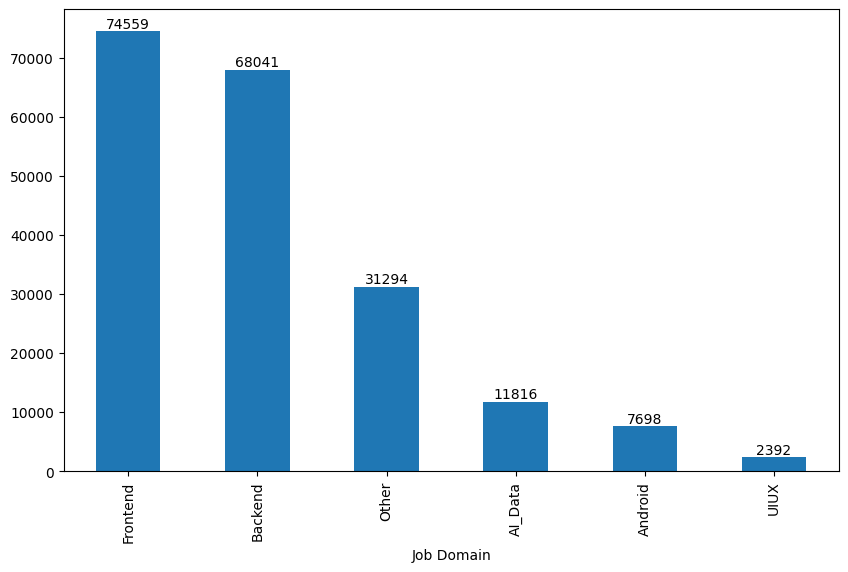

In [ ]:
ax = df["Job Domain"].value_counts().plot(kind="bar", figsize=(10, 6))
for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
    )

In [ ]:
n_users = df["Applicant ID"].nunique()
print(f"تعداد کاربران یکتا: {n_users}")

n_items = df["Job ID"].nunique()
print(f"تعداد آگهی های یکتا (آیتم‌ها): {n_items}")

تعداد کاربران یکتا: 29570
تعداد آگهی های یکتا (آیتم‌ها): 13799


In [ ]:
num_users = df["Applicant ID"].nunique()
num_ads = df["Job ID"].nunique()

num_interactions = len(df)
sparsity = 1.0 - (num_interactions / (num_users * num_ads))

print(f"تعداد کاربران منحصر به فرد: {num_users}")
print(f"تعداد آگهی‌های منحصر به فرد: {num_ads}")
print(f"تعداد کل رزومه‌ها (تعاملات): {num_interactions}")
print("-" * 30)
print(f"پراکندگی (Sparsity) ماتریس: {sparsity:.2%}")

تعداد کاربران منحصر به فرد: 29570
تعداد آگهی‌های منحصر به فرد: 13799
تعداد کل رزومه‌ها (تعاملات): 195800
------------------------------
پراکندگی (Sparsity) ماتریس: 99.95%


In [ ]:
# ایجاد ستون interaction با مقدار ثابت 1
df["interaction"] = 1

# ایجاد ستون ترکیبی Job_ID_Title
df["Job_ID_Title"] = df["Job ID"].astype(str) + "_" + df["Job Title"]

In [ ]:
min_apps_per_job = 15
min_jobs_per_user = 10

# فیلتر کردن آگهی‌ها (Job ID) که تعداد درخواست‌ها کمتر از 15 است
job_counts = df["Job ID"].value_counts()
jobs_to_keep = job_counts[job_counts >= min_apps_per_job].index
df = df[df["Job ID"].isin(jobs_to_keep)]

# فیلتر کردن کاربران (Applicant ID) که کمتر از 10 درخواست ثبت کرده‌اند
user_counts = df["Applicant ID"].value_counts()
users_to_keep = user_counts[user_counts >= min_jobs_per_user].index
df = df[df["Applicant ID"].isin(users_to_keep)]

In [ ]:
# محاسبه و نمایش اطلاعات پس از فیلتر
num_users = df["Applicant ID"].nunique()
num_ads = df["Job ID"].nunique()
num_interactions = len(df)
sparsity = 1.0 - (num_interactions / (num_users * num_ads))

print(f"تعداد کاربران منحصر به فرد: {num_users}")
print(f"تعداد آگهی‌های منحصر به فرد: {num_ads}")
print(f"تعداد کل رزومه‌ها (تعاملات): {num_interactions}")
print("-" * 30)
print(f"پراکندگی (Sparsity) ماتریس: {sparsity:.2%}")

تعداد کاربران منحصر به فرد: 3746
تعداد آگهی‌های منحصر به فرد: 3267
تعداد کل رزومه‌ها (تعاملات): 79248
------------------------------
پراکندگی (Sparsity) ماتریس: 99.35%


In [ ]:
user_item_matrix = df.pivot_table(
    index="Applicant ID", columns="Job_ID_Title", values="interaction", fill_value=0
)

In [17]:
print(user_item_matrix.shape)
user_item_matrix.head(15)

(3746, 3267)


Job_ID_Title,100008_متخصص هوش مصنوعی (NLP),100272_طراح وب,100608_کارآموز برنامه‌نویسی Front-end,100632_کارآموز برنامه‌نویسی Android,100680_توسعه‌دهنده Front-end,101064_توسعه‌دهنده Front-end,101328_مهندس نرم‌افزار,101376_مهندس نرم‌افزار - Front-end,101400_توسعه‌دهنده Front-end,102264_کارآموز برنامه‌نویسی,...,99240_برنامه‌نویس Python) Back-End),99264_PHP Developer,99336_برنامه‌نویس حرفه‌ای موبایل,99624_توسعه‌دهنده پایتون,99648_توسعه‌دهنده جوان Front-end,99672_توسعه‌دهنده Front-end,99696_توسعه‌دهنده Android,99720_توسعه‌دهنده Front-end,99744_برنامه‌نویس Front-end,99768_توسعه‌دهنده Back-end
Applicant ID,,,,,,,,,,,,,,,,,,,,,
12000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22416.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37872.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58512.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66624.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97872.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100944.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
106080.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
top_15_users = df["Applicant ID"].value_counts().head(15)
print(top_15_users)

Applicant ID
10894224.0    198
3902592.0     184
3237456.0     183
5813664.0     147
5105952.0     141
5401248.0     140
2275008.0     136
8049936.0     115
5202816.0     112
3435024.0     110
2674848.0     104
7769856.0     103
5500704.0     101
9985248.0     101
1395696.0      97
Name: count, dtype: int64


In [19]:
from scipy.spatial.distance import pdist, squareform

# user_item_matrix: ماتریس کاربر-آیتم با 0 و 1

# فاصله ژاکارد بین ردیف‌ها (کاربران) را محاسبه کن
jaccard_distances = pdist(user_item_matrix.values, metric="jaccard")

# تبدیل فاصله به شباهت
jaccard_similarity_array = 1 - squareform(jaccard_distances)

# تبدیل به DataFrame با ایندکس و ستون آیدی کاربران
jaccard_similarity_df = pd.DataFrame(
    jaccard_similarity_array,
    index=user_item_matrix.index,
    columns=user_item_matrix.index,
)

In [ ]:
user_similarity_jaccard = pd.DataFrame(
    jaccard_similarity_array,
    index=user_item_matrix.index,
    columns=user_item_matrix.index,
)

In [ ]:
def recommender_system(user_id, top_n_neighbors=10, top_n_jobs=10):
    # 1. دریافت سری شباهت کاربر به دیگر کاربران و حذف خودش
    user_similarities = user_similarity_jaccard.loc[user_id].drop(user_id)

    # 2. انتخاب 10 همسایه با بیشترین شباهت
    top_neighbors = user_similarities.nlargest(top_n_neighbors)

    # 3. گرفتن ماتریس تعامل این همسایه‌ها
    neighbors_interactions = user_item_matrix.loc[top_neighbors.index]

    # 4. ضرب ماتریس تعامل در وزن شباهت هر همسایه (وزن‌ها به عنوان سری)
    weighted_scores = neighbors_interactions.T.dot(top_neighbors)

    # 5. گرفتن تعامل‌های کاربر هدف (برای حذف آگهی‌هایی که قبلاً ارسال کرده)
    user_interactions = user_item_matrix.loc[user_id]

    # 6. حذف آگهی‌هایی که کاربر قبلاً تعامل داشته است
    weighted_scores = weighted_scores[user_interactions == 0]

    # 7. انتخاب 10 آگهی با بیشترین امتیاز
    recommended_jobs = weighted_scores.nlargest(top_n_jobs)

    # 8. آماده کردن دیتافریم خروجی
    # فرض می‌کنیم ستون Job Domain را در دیتافریم df داریم، و با Job_ID_Title کلید شده
    job_domains = df.drop_duplicates("Job_ID_Title").set_index("Job_ID_Title")[
        "Job Domain"
    ]

    recommendations_df = pd.DataFrame(
        {
            "Job_ID_Title": recommended_jobs.index,
            "Score": recommended_jobs.values,
            "Job Domain": job_domains.loc[recommended_jobs.index].values,
        }
    )

    # مرتب سازی بر اساس امتیاز نزولی
    recommendations_df = recommendations_df[["Job_ID_Title", "Score", "Job Domain"]]

    return recommendations_df.reset_index(drop=True)

In [ ]:
def get_user_applied_jobs_with_domain(
    user_id, main_df, num_jobs_to_return=15, user_item_matrix_df=user_item_matrix
):

    if user_id not in user_item_matrix_df.index:

        print(f"خطا: کاربر با شناسه '{user_id}' در ماتریس کاربر-آیتم یافت نشد.")

        return pd.DataFrame(columns=["Job_ID_Title", "Job Domain"])


    user_interactions_series = user_item_matrix_df.loc[user_id]

    applied_jobs_series = user_interactions_series[user_interactions_series >= 1.0]

    applied_jobs_list = applied_jobs_series.index.tolist()


    if not applied_jobs_list:

        print(f"کاربر '{user_id}' به هیچ شغلی رزومه نفرستاده است.")

        return pd.DataFrame(columns=["Job_ID_Title", "Job Domain"])


    applied_jobs_details = main_df[main_df["Job_ID_Title"].isin(applied_jobs_list)]

    result_df = applied_jobs_details[["Job_ID_Title", "Job Domain"]]


    return result_df.head(num_jobs_to_return)



get_user_applied_jobs_with_domain(user_id=3902592.0, main_df=df)

,Job_ID_Title,Job Domain
18,432192_Junior Python Developer,Backend
36,352320_Junior Front-end Developer (React),Frontend
46,111048_کارآموز برنامه‌نویس Front End,Frontend
73,108264_کارآموز Front-end,Frontend
86,347904_برنامه‌نویس Front-end,Frontend
108,281952_برنامه‌نویس Front-end,Frontend
117,412416_Front-end Developer,Frontend
137,331848_برنامه‌نویس Front-end,Frontend
170,508416_(Django) Senior Python Developer,Backend
174,523944_توسعه‌دهنده Back-end,Backend
